In [1]:
# %matplotlib inline
%run utils.ipynb

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import cartopy.crs as ccrs

import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns
import kinesis as kn
import gapipes as gp

kn.set_mpl_style()

In [3]:
%%time
r = gp.gaia.query(
    """
-- From Hipparcos-Gaia cross-match, get positions and
-- proper motion "residual" between Gaia-measured proper motion and
-- proper motion calculated as positional difference between two epochs.
SELECT
    gaia.ra, gaia.dec,
    gaia.pmra - (gaia.ra - hip.ra) *3600000 * COS(RADIANS(gaia.dec)) / 24.25 AS "delta_pmra",
    gaia.pmdec - (gaia.dec - hip.dec) *3600000/ 24.25 as "delta_pmdec"
FROM gaiadr2.gaia_source gaia
    JOIN gaiadr2.hipparcos2_best_neighbour hip_match
    ON gaia.source_id = hip_match.source_id
    JOIN public.hipparcos_newreduction hip
    ON hip_match.original_ext_source_id = hip.hip
"""
)
print(f"{len(r)} rows")

83034 rows
CPU times: user 228 ms, sys: 78 ms, total: 306 ms
Wall time: 15.3 s


In [4]:
from scipy.stats import gaussian_kde, binned_statistic_2d
import scipy.ndimage as ndimage

In [5]:
def plot_binned_statistic_2d(
    x,
    y,
    values,
    statistic="mean",
    bins=10,
    range=None,
    gaussian_filter=None,
    ax=None,
    **kwargs,
):
    if ax is None:
        ax = plt.gca()
    s, xe, ye, bn = binned_statistic_2d(
        x, y, values, statistic=statistic, bins=bins, range=range
    )
    if gaussian_filter is not None:
        s1 = s.copy()
        s1[np.isnan(s1)] = 0
        img1 = ndimage.gaussian_filter(s1, **gaussian_filter)

        s2 = s.copy() * 0.0 + 1.0
        s2[np.isnan(s)] = 0.0
        img2 = ndimage.gaussian_filter(s2, **gaussian_filter)

        img = img1 / img2
    else:
        img = s
    x, y = np.meshgrid(xe, ye)
#     ax.pcolormesh(x, y, img.T, **kwargs)
#     return ax
    return x, y, img

In [6]:
%store -r out_full
d = out_full.loc[out_full['Member_r19']!='other']

KeyboardInterrupt: 

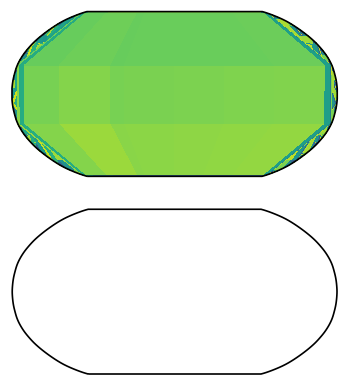

In [7]:
fig, ax = plt.subplots(2, 1, subplot_kw=dict(projection=ccrs.Robinson()))
r_nona = r.dropna()
out = plot_binned_statistic_2d(
    r_nona["ra"].values,
    r_nona["dec"].values,
    r_nona["delta_pmra"].values,
    gaussian_filter={"sigma": 8, "mode": "wrap"},
    bins=(361, 181),
    ax=ax[0],
    transform=ccrs.RotatedPole(),
    vmin=-0.2,
    vmax=0.2,
    cmap="RdYlBu",
)
ax[0].pcolormesh(out[0],out[1],out[2].T,transform=ccrs.RotatedPole())
# plot_binned_statistic_2d(
#     r_nona["ra"],
#     r_nona["dec"],
#     r_nona["delta_pmdec"],
#     gaussian_filter={"sigma": 3, "mode": "wrap"},
#     bins=(181, 91),
#     ax=ax[1],
#     transform=ccrs.RotatedPole(),
#     vmin=-0.2,
#     vmax=0.2,
#     cmap="RdYlBu",
# )
for cax in ax:
    cax.scatter(d['ra'], d['dec'], transform=ccrs.Geodetic(), s=1, c='k')
    cax.invert_xaxis()
    # first of the collections is pcolormesh of the background
    cb = plt.colorbar(cax.collections[0], ax=cax)
    cb.ax.tick_params(width=1, length=5)

ax[0].set_title(r'$\Delta$pmra')
ax[1].set_title(r'$\Delta$pmdec')
fig.tight_layout()
# fig.savefig("../plots/hip-gaia-residual-proper-motion.pdf");

In [9]:
%%time
deltapm_healpix = gp.gaia.query(
    """
-- From Hipparcos-Gaia cross-match, get average positions and
-- proper motion "residual" grouped by healpix pixels.
SELECT
    avg(gaia.ra) as "avg_ra", avg(gaia.dec) as "avg_dec",
    gaia_healpix_index(4, gaia.source_id) AS healpix_6,
    avg(gaia.pmra - (gaia.ra - hip.ra) *3600000 * COS(RADIANS(gaia.dec)) / 24.25) as "avg_delta_pmra",
    avg(gaia.pmdec - (gaia.dec - hip.dec) *3600000/ 24.25) as "avg_delta_pmdec",
    count(gaia.source_id)
FROM gaiadr2.gaia_source gaia
    JOIN gaiadr2.hipparcos2_best_neighbour hip_match
    ON gaia.source_id = hip_match.source_id
    JOIN public.hipparcos_newreduction hip
    ON hip_match.original_ext_source_id = hip.hip
GROUP BY healpix_6
ORDER BY healpix_6
"""
)

CPU times: user 52.2 ms, sys: 8.97 ms, total: 61.2 ms
Wall time: 1.63 s


number of missing pixels = 0
number of sources per pixel
0.05    17.0
0.50    26.0
0.95    42.0
Name: COUNT, dtype: float64


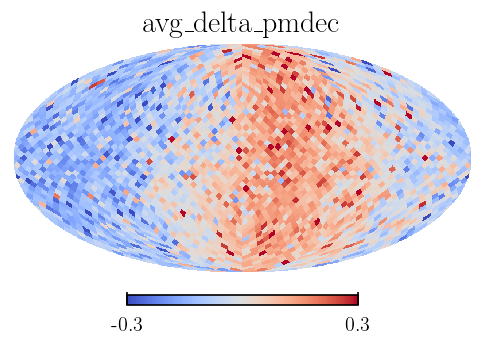

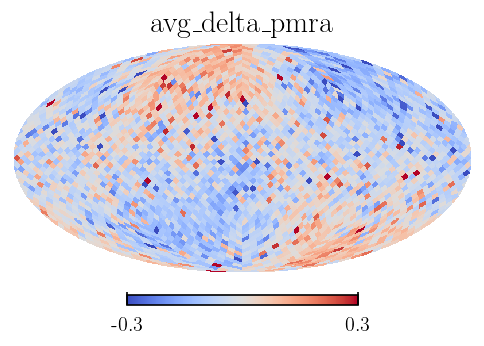

In [11]:
import healpy as hp

# there should be no missing healpix pixels for plotting
npix = hp.nside2npix(2 ** 4)
missing_ipix = sorted(list(set(range(npix)) - set(deltapm_healpix["healpix_6"].values)))
print("number of missing pixels =", len(missing_ipix))
print("number of sources per pixel")
print(deltapm_healpix["COUNT"].quantile([0.05, 0.5, 0.95]))


fig = plt.figure(figsize=(4, 4))
hp.mollview(
    deltapm_healpix["avg_delta_pmdec"],
    nest=True,
    min=-0.3,
    max=0.3,
    cmap="coolwarm",
    fig=fig.number,
    title="avg\_delta\_pmdec",
)
fig = plt.figure(figsize=(4, 4))
hp.mollview(
    deltapm_healpix["avg_delta_pmra"],
    nest=True,
    min=-0.3,
    max=0.3,
    cmap="coolwarm",
    fig=fig.number,
    title="avg\_delta\_pmra",
)

In [45]:
%store -r out_full
out_full_orig = out_full.copy()

In [46]:
def add_cartesian_xv(df):
    df["x"], df["y"], df["z"] = df.g.icrs.cartesian.xyz.value
    df["vx"], df["vy"], df["vz"] = df.g.icrs.velocity.d_xyz.value
    df["gx"], df["gy"], df["gz"] = df.g.galactic.cartesian.xyz.value
    df["gvx"], df["gvy"], df["gvz"] = df.g.galactic.velocity.d_xyz.value


add_cartesian_xv(out_full_orig)
out_full = out_full_orig.copy()
out_full.g.correct_brightsource_pm();

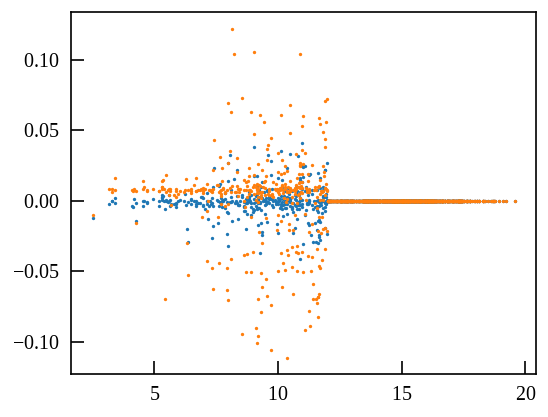

In [48]:
plt.scatter(
    out_full["phot_g_mean_mag"],
    (out_full["pmra"] - out_full_orig["pmra"]) / out_full["parallax"]*4.74,
    s=1,
);
plt.scatter(
    out_full["phot_g_mean_mag"],
    (out_full["pmdec"] - out_full_orig["pmdec"]) / out_full["parallax"]*4.74,
    s=1,
);

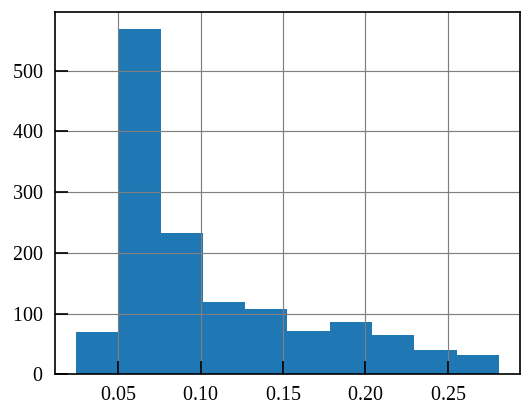

In [56]:
(4.74*0.3/out_full['parallax']).hist()

In [49]:
df_orig = out_full_orig.loc[out_full['in_dr2']==True].copy()
df = out_full.loc[out_full['in_dr2']==True].copy()
print(len(df))

515


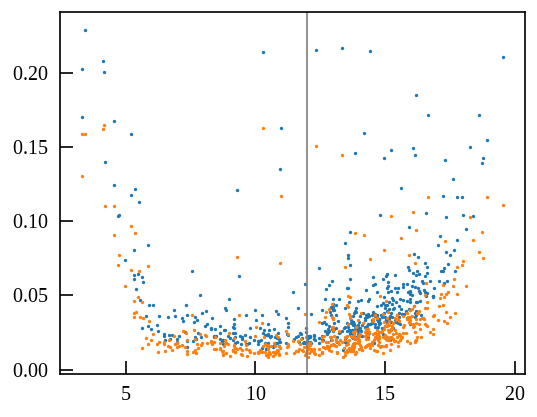

In [55]:
plt.scatter(df['phot_g_mean_mag'], df['pmra_error']/df['parallax']*4.74,s=1);
plt.scatter(df['phot_g_mean_mag'], df['pmdec_error']/df['parallax']*4.74,s=1);
plt.axvline(12,c='C7');

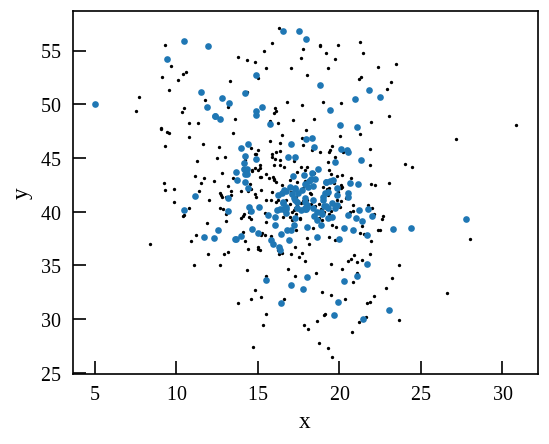

In [42]:
# out_full.plot.scatter('x','y',c='C3',s=1,)
df.query('phot_g_mean_mag>12').plot.scatter('x','y',c='k',s=1,ax=plt.gca())
df.query('phot_g_mean_mag<12').plot.scatter('x','y',ax=plt.gca(),s=9);
# plt.colorbar()